In [73]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
     

In [74]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

train_df["is_train"] = True
test_df["is_train"] = False
test_df["SalePrice"] = np.nan

full_df = pd.concat([train_df, test_df], ignore_index=True)

In [79]:
categorical_features = full_df.select_dtypes(include=["object"]).columns
numerical_features = full_df.select_dtypes(include=[np.number]).columns

full_df[categorical_features] = SimpleImputer(strategy="most_frequent").fit_transform(full_df[categorical_features])
full_df[numerical_features] = SimpleImputer(strategy="median").fit_transform(full_df[numerical_features])


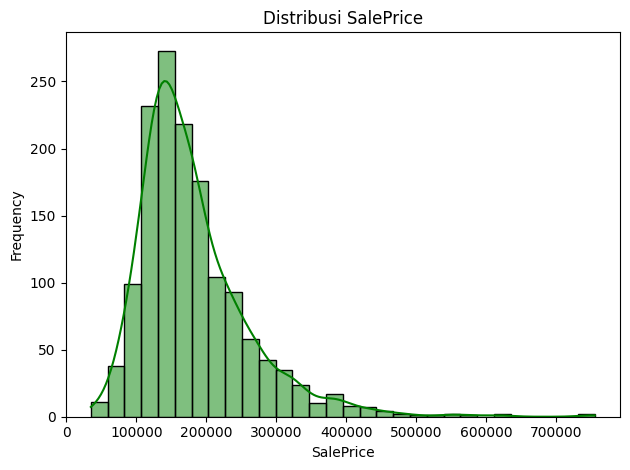

In [82]:
sns.histplot(eda_df["SalePrice"], kde=True, color="green", bins=30)
plt.title("Distribusi SalePrice")
plt.xlabel("SalePrice")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [83]:
# Encode kategorikal
full_df = pd.get_dummies(full_df, columns=categorical_features, drop_first=True)
     

# Normalisasi numerik
scaler = StandardScaler()
full_df[numerical_features] = scaler.fit_transform(full_df[numerical_features])
     

# Pisahkan kembali train dan test
train_final = full_df[full_df["is_train"] == True].drop(columns=["is_train"])
test_final = full_df[full_df["is_train"] == False].drop(columns=["is_train", "SalePrice"])

In [84]:
X = train_final.drop(columns=["SalePrice"])
y = train_final["SalePrice"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
     

In [98]:
param_grid = {
    "max_depth": [3, 5, 7, 10, 15, 20, None],
    "min_samples_split": [2, 5, 10, 15],
    "min_samples_leaf": [1, 2, 5, 10],
    "max_features": [None, "sqrt", "log2"]
}

grid_search = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_grid=param_grid,
    cv=10,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 336 candidates, totalling 3360 fits


GridSearchCV(cv=10, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10, 15, 20, None],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 5, 10, 15]},
             scoring='neg_mean_squared_error', verbose=1)

In [99]:
best_dt_model = grid_search.best_estimator_

y_train_pred = best_dt_model.predict(X_train)
y_val_pred = best_dt_model.predict(X_val)

train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)
val_mse = mean_squared_error(y_val, y_val_pred)
val_rmse = np.sqrt(val_mse)

print("=== Decision Tree (Optimized v2) ===")
print(f"Train R² : {train_r2:.4f}")
print(f"Valid R² : {val_r2:.4f}")
print(f"MSE      : {val_mse:.4f}")
print(f"RMSE     : {val_rmse:.4f}")
print("Best Parameters:", grid_search.best_params_)

=== Decision Tree (Optimized v2) ===
Train R² : 0.8926
Valid R² : 0.8016
MSE      : 0.4635
RMSE     : 0.6808
Best Parameters: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 2}


In [ ]:
best_dt_model = grid_search.best_estimator_

# Overfitting Check
print(">> Overfitting Check (Decision Tree):")
y_train_pred = best_dt_model.predict(X_train)
y_val_pred = best_dt_model.predict(X_val)

train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)

print(f"Train R² : {train_r2:.4f}")
print(f"Valid R² : {val_r2:.4f}")
print("Gap:", abs(train_r2 - val_r2))

>> Overfitting Check (Decision Tree):
Train R² : 0.8926
Valid R² : 0.8016
Gap: 0.09105044279634289


### 📊 Evaluasi Model Regresi (Decision Tree)

#### 1. 🎯 Mean Squared Error (MSE)

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

- \( y_i \): Nilai aktual
- \( \hat{y}_i \): Nilai prediksi
- \( n \): Jumlah data
- MSE mengukur rata-rata kuadrat kesalahan antara prediksi dan nilai asli.
- Semakin kecil nilainya, semakin baik modelnya.

---

#### 2. 🧮 Root Mean Squared Error (RMSE)

$$
\text{RMSE} = \sqrt{\text{MSE}} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
$$


- RMSE menyatakan seberapa jauh rata-rata prediksi meleset dari nilai aktual.
- Karena satuannya sama dengan target, RMSE lebih mudah diinterpretasikan dibanding MSE.

---

#### 3. 📈 R-squared (R²) — Koefisien Determinasi

$$
R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}
$$

- \( \bar{y} \): Rata-rata dari nilai aktual
- R² menunjukkan seberapa besar proporsi variansi data yang dapat dijelaskan oleh model.
- Nilai:
  - \( R^2 = 1 \): Model sempurna
  - \( R^2 = 0 \): Tidak lebih baik dari rata-rata
  - \( R^2 < 0 \): Lebih buruk dari sekadar nebak rata-rata

---

#### ✅ Ringkasan

| Metric | Tujuan                     | Ideal         |
|--------|-----------------------------|---------------|
| MSE    | Kuadrat error rata-rata     | Sekecil mungkin |
| RMSE   | Rata-rata selisih prediksi  | Sekecil mungkin |
| R²     | Proporsi variansi dijelaskan | Sedekat mungkin ke 1 |